# Matrix matrix multiplication performance

In [2]:
import iarray as ia
import numpy as np
from itertools import zip_longest as izip
from time import time
import ctypes
import matplotlib.pyplot as plt
%matplotlib inline


mkl_rt = ctypes.CDLL('libmkl_rt.so')
mkl_set_num_threads = mkl_rt.MKL_Set_Num_Threads
nrep = 3

## Data

In [55]:
shape = [4000, 4000]

pshape = None
bshape = [4000, 4000]

pshape2 = [1000, 1000]
bshape2 = [1000, 1000]

size = int(np.prod(shape))

## Multithreading

In [ ]:
max_num_threads = 8
res = []

for num_threads in range(1, max_num_threads + 1):
    print(f"Num. threads: {num_threads}")
    mkl_set_num_threads(num_threads)
    cfg = ia.Config(max_num_threads=num_threads)
    ctx = ia.Context(cfg)

    # Numpy and plainbuffer
    a = ia.linspace(ctx, size, -1, 1, shape=shape, pshape=pshape)
    an = ia.iarray2numpy(ctx, a)

    b = ia.linspace(ctx, size, -1, 1, shape=shape, pshape=pshape)
    bn = ia.iarray2numpy(ctx, b)

    t0 = time()
    for _ in range(nrep):
        cn2 = np.matmul(an, bn)
    t1 = time()
    t_np = (t1 - t0) / nrep

    t0 = time()
    for i in range(nrep):
        c = ia.matmul(ctx, a, b, bshape, bshape)
    t1 = time()
    t_ia = (t1 - t0) / nrep

    # Superchunk without compression
    mkl_set_num_threads(num_threads)
    cfg = ia.Config(max_num_threads=num_threads)
    ctx = ia.Context(cfg)

    a = ia.linspace(ctx, size, -1, 1, shape=shape, pshape=pshape2)

    b = ia.linspace(ctx, size, -1, 1, shape=shape, pshape=pshape2)

    t0 = time()
    for i in range(nrep):
        c = ia.matmul(ctx, a, b, bshape2, bshape2)
    t1 = time()
    t_ia_s = (t1 - t0) / nrep
    
    # Superchunk with compression
    mkl_set_num_threads(num_threads)
    cfg = ia.Config(max_num_threads=num_threads, compression_level=5)
    ctx = ia.Context(cfg)

    a = ia.linspace(ctx, size, -1, 1, shape=shape, pshape=pshape2)

    b = ia.linspace(ctx, size, -1, 1, shape=shape, pshape=pshape2)

    t0 = time()
    for i in range(nrep):
        c = ia.matmul(ctx, a, b, bshape2, bshape2)
    t1 = time()
    t_ia_sc = (t1 - t0) / nrep

    # Append data
    
    res.append([t_np, t_ia, t_ia_s, t_ia_sc])

Num. threads: 1
Num. threads: 2
Num. threads: 3
Num. threads: 4
Num. threads: 5
Num. threads: 6


## Results

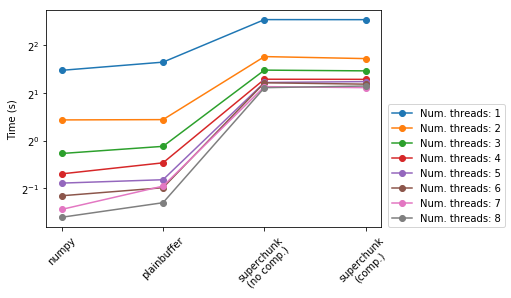

In [54]:
xticks = ("numpy", "plainbuffer", "superchunk\n(no comp.)", "superchunk\n(comp.)")
plt.xticks(range(len(xticks)), xticks)
for i in range(0, max_num_threads):
    plt.semilogy(xticks, res[i], "o-", label=f"Num. threads: {i+1}", basey=2)
plt.xticks(rotation=45)
plt.ylabel("Time (s)")
plt.ylim(0)
plt.legend(loc=(1.02, 0))
plt.show()